In [1]:
import pandas as pd 
import os 
import numpy as np 
from pathlib import Path
from typing import *
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# Data Functions

In [2]:
ROOT = os.path.dirname(os.getcwd())+"/data"

def load(path:Path, sep="|"):
    return pd.read_csv(path, sep=sep, na_values=["nan"])

def collect_time_(df:pd.DataFrame,column:str):
    data_times = pd.to_datetime(df[column]).dt
    df["year"] = data_times.year
    df["month"] = data_times.month
    del df_meteo[column]

def set_pickle(object_to_save:object, path:Path):
    with open(path, "wb") as handle:
        pickle.dump(object_to_save, handle, protocol=pickle.HIGHEST_PROTOCOL)    

def get_pickle(path:Path):
    with open(path, "rb") as handle:
        o=pickle.load(handle)     
    return o

def convert_altitud(df:pd.DataFrame):
    df["ALTITUD"] = df["ALTITUD"].apply(lambda x: str(x).split("-"))
    df = df.explode("ALTITUD")
    df["ALTITUD"] = df["ALTITUD"].apply(lambda x: int(x) if x!= "nan" else x)
    
    return df

In [3]:
df_train = load(ROOT+"/UH_2023_TRAIN.txt")

In [4]:
df_meteo_by_day = load(ROOT+"/DATOS_METEO_AGG_DAY.csv", sep=",") 
df_meteo_by_month = load(ROOT+"/DATOS_METEO_AGG_MONTH.csv", sep=",")

In [5]:
df_train

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION
0,14,76953,515,4,660,26,2,0,1,0.0000,22215.0
1,14,84318,515,4,660,26,2,0,1,0.0000,22215.0
2,14,85579,340,4,520,32,2,0,1,0.0000,20978.0
3,14,69671,340,4,520,32,2,0,1,0.0000,40722.0
4,14,14001,852,14,NaN,81,1,0,1,0.0000,14126.0
...,...,...,...,...,...,...,...,...,...,...,...
9596,22,37461,239,6,700,52,2,0,1,3.6800,NaN
9597,22,58769,239,6,700,32,2,0,1,4.2500,NaN
9598,22,58769,239,6,700,59,2,0,1,4.0700,NaN
9599,22,88928,239,6,700,40,2,0,1,4.5727,NaN


In [6]:
def list_of_str_to_altitude(x: float, statistic: str = "mean"):
    x = [int(i) for i in str(x).split("-")]
    if statistic == "mean":
        return sum(x) / len(x)
    elif statistic == "max":
        return max(x)
    elif statistic == "min":
        return min(x)

In [7]:
# Deal with altitudes in ranges by using the mean

df_train["ALTITUD"] = df_train["ALTITUD"].apply(lambda x: list_of_str_to_altitude(x, "max") if not pd.isnull(x) else 0)
df_train["ALTITUD"] = df_train["ALTITUD"].round()

<Axes: >

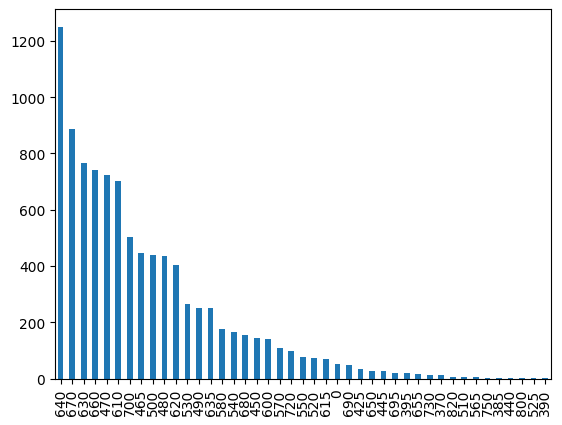

In [8]:
df_train["ALTITUD"].value_counts().plot(kind="bar")

In [9]:
train_joined_by_day = df_train.merge(df_meteo_by_day, how='inner', on=["CAMPAÑA", "ID_ESTACION"])  # Ideally how='left'

In [10]:
train_joined_by_month = df_train.merge(df_meteo_by_month, how='inner', on=["CAMPAÑA", "ID_ESTACION"])  # Ideally how='left'

In [11]:
# We have no data from meteo for 2014! So we will miss al the samples before 2015, more than 1k! :(

In [12]:
train_joined_by_day.shape, train_joined_by_month.shape

((8453, 10625), (8453, 359))

In [13]:
display(train_joined_by_day)

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,...,windSpeed_month_12_day_22,windSpeed_month_12_day_23,windSpeed_month_12_day_24,windSpeed_month_12_day_25,windSpeed_month_12_day_26,windSpeed_month_12_day_27,windSpeed_month_12_day_28,windSpeed_month_12_day_29,windSpeed_month_12_day_30,windSpeed_month_12_day_31
0,15,48626,302,13,600,32,2,0,1,0.0000,...,6.229167,5.500000,5.000000,5.641667,5.700000,8.125000,7.183333,7.300,9.121739,9.254167
1,15,47921,302,13,600,32,2,0,1,0.0000,...,6.229167,5.500000,5.000000,5.641667,5.700000,8.125000,7.183333,7.300,9.121739,9.254167
2,15,14001,852,14,0,81,1,0,1,0.0000,...,6.162500,5.429167,5.041667,5.745833,5.691667,8.083333,7.191667,7.400,9.308696,9.529167
3,15,17059,852,14,0,81,1,0,1,0.0000,...,6.162500,5.429167,5.041667,5.745833,5.691667,8.083333,7.191667,7.400,9.308696,9.529167
4,15,87611,602,14,0,81,1,0,1,0.0000,...,6.162500,5.429167,5.041667,5.745833,5.691667,8.083333,7.191667,7.400,9.308696,9.529167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8448,22,37461,239,6,700,52,2,0,1,3.6800,...,7.275000,7.275000,7.275000,7.275000,7.275000,7.275000,7.275000,7.275,7.275000,7.275000
8449,22,58769,239,6,700,32,2,0,1,4.2500,...,7.275000,7.275000,7.275000,7.275000,7.275000,7.275000,7.275000,7.275,7.275000,7.275000
8450,22,58769,239,6,700,59,2,0,1,4.0700,...,7.275000,7.275000,7.275000,7.275000,7.275000,7.275000,7.275000,7.275,7.275000,7.275000
8451,22,88928,239,6,700,40,2,0,1,4.5727,...,7.275000,7.275000,7.275000,7.275000,7.275000,7.275000,7.275000,7.275,7.275000,7.275000


In [14]:
display(train_joined_by_month)

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,...,windSpeed_month_3,windSpeed_month_4,windSpeed_month_5,windSpeed_month_6,windSpeed_month_7,windSpeed_month_8,windSpeed_month_9,windSpeed_month_10,windSpeed_month_11,windSpeed_month_12
0,15,48626,302,13,600,32,2,0,1,0.0000,...,9.559105,9.559105,9.559105,9.559105,9.559105,10.144028,9.001268,8.228202,8.677514,6.048850
1,15,47921,302,13,600,32,2,0,1,0.0000,...,9.559105,9.559105,9.559105,9.559105,9.559105,10.144028,9.001268,8.228202,8.677514,6.048850
2,15,14001,852,14,0,81,1,0,1,0.0000,...,9.579475,9.579475,9.579475,9.579475,9.579475,10.187778,9.135211,8.355995,8.801676,6.089986
3,15,17059,852,14,0,81,1,0,1,0.0000,...,9.579475,9.579475,9.579475,9.579475,9.579475,10.187778,9.135211,8.355995,8.801676,6.089986
4,15,87611,602,14,0,81,1,0,1,0.0000,...,9.579475,9.579475,9.579475,9.579475,9.579475,10.187778,9.135211,8.355995,8.801676,6.089986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8448,22,37461,239,6,700,52,2,0,1,3.6800,...,14.390860,13.393750,9.005511,8.964117,8.964117,8.964117,8.964117,8.964117,8.964117,8.964117
8449,22,58769,239,6,700,32,2,0,1,4.2500,...,14.390860,13.393750,9.005511,8.964117,8.964117,8.964117,8.964117,8.964117,8.964117,8.964117
8450,22,58769,239,6,700,59,2,0,1,4.0700,...,14.390860,13.393750,9.005511,8.964117,8.964117,8.964117,8.964117,8.964117,8.964117,8.964117
8451,22,88928,239,6,700,40,2,0,1,4.5727,...,14.390860,13.393750,9.005511,8.964117,8.964117,8.964117,8.964117,8.964117,8.964117,8.964117


In [15]:
print("The following ID_FINCA don't have ALTITUD:", *train_joined_by_day[train_joined_by_day["ALTITUD"] == 0]["ID_FINCA"].unique().tolist())

The following ID_FINCA don't have ALTITUD: 14001 17059 87611 12257 97286 43323 28875 42732 55056 9086 83458 31072 78460 62285


### Filling ALTITUD

In [16]:
drop_cols = ['CAMPAÑA', 'ID_FINCA', 'ID_ZONA', 'ID_ESTACION', 'ALTITUD', 'VARIEDAD', 'MODO', 'TIPO', 'COLOR', 'SUPERFICIE', 'PRODUCCION']

In [17]:
# Train KNeighborsClassifier

train = train_joined_by_month[train_joined_by_month["ALTITUD"] != 0]
Y_train = train["ALTITUD"]
X_train = train.drop(["ALTITUD"] + drop_cols, axis=1)

test = train_joined_by_month[train_joined_by_month["ALTITUD"] == 0]
X_test = test.drop(["ALTITUD"] + drop_cols, axis=1)

# fit the classifier to the training data
clf_model = KNeighborsClassifier(n_neighbors=1)
clf_model.fit(X_train, Y_train)

# predict the missing values using the trained regression model
predicted_values = clf_model.predict(X_test)

# fill in the missing values in the original dataframe with the predicted values
train_joined_by_month.loc[train_joined_by_month["ALTITUD"] == 0, "ALTITUD"] = predicted_values

<Axes: >

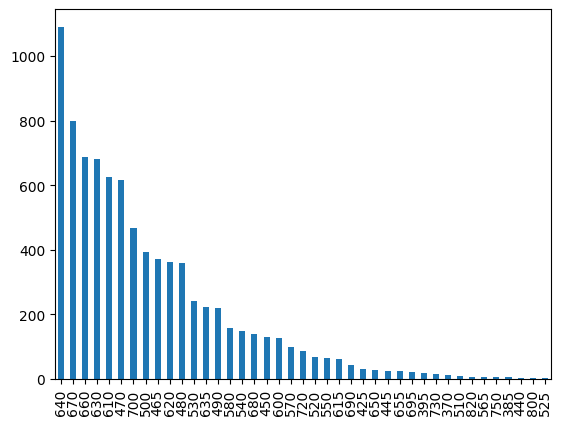

In [18]:
train_joined_by_month["ALTITUD"].value_counts().plot(kind="bar")

In [19]:
# Train KNeighborsClassifier

train = train_joined_by_day[train_joined_by_day["ALTITUD"] != 0]
Y_train = train["ALTITUD"]
X_train = train.drop(["ALTITUD"] + drop_cols, axis=1)

test = train_joined_by_day[train_joined_by_day["ALTITUD"] == 0]
X_test = test.drop(["ALTITUD"] + drop_cols, axis=1)

# fit the classifier to the training data
clf_model = KNeighborsClassifier(n_neighbors=1)
clf_model.fit(X_train, Y_train)

# predict the missing values using the trained regression model
predicted_values = clf_model.predict(X_test)

# fill in the missing values in the original dataframe with the predicted values
train_joined_by_day.loc[train_joined_by_day["ALTITUD"] == 0, "ALTITUD"] = predicted_values

<Axes: >

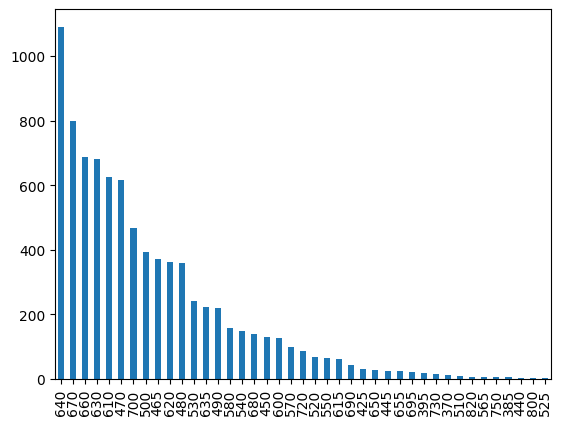

In [20]:
train_joined_by_day["ALTITUD"].value_counts().plot(kind="bar")

### Filling SUPERFICIE

<Axes: >

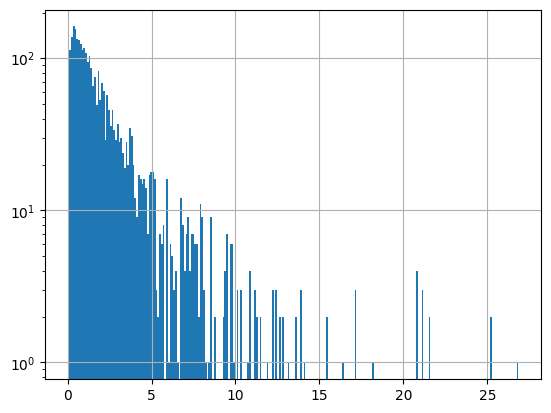

In [21]:
train_joined_by_month[train_joined_by_month["SUPERFICIE"] != 0]["SUPERFICIE"].hist(bins=256, log=True)

In [26]:
mean_superficie = train_joined_by_month.loc[train_joined_by_month["SUPERFICIE"] != 0].mean()
train_joined_by_month.loc[train_joined_by_month["SUPERFICIE"] == 0, "SUPERFICIE"] = mean_superficie

<Axes: >

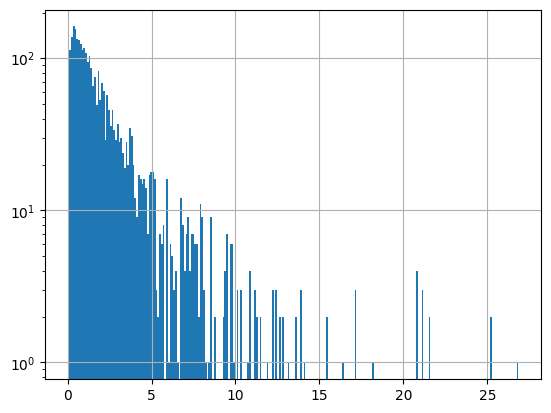

In [27]:
train_joined_by_month["SUPERFICIE"].hist(bins=256, log=True)

In [28]:
mean_superficie = train_joined_by_day.loc[train_joined_by_day["SUPERFICIE"] != 0].mean()
train_joined_by_day.loc[train_joined_by_day["SUPERFICIE"] == 0, "SUPERFICIE"] = mean_superficie

In [29]:
assert False == True, "DO NOT EXECUTE EVERYTHING!"

AssertionError: DO NOT EXECUTE EVERYTHING!

In [30]:
train_joined_by_day.to_csv("../data/DATA_TRAIN_JOINED_DAYS.csv", header=True, index=False)

In [31]:
train_joined_by_month.to_csv("../data/DATA_TRAIN_JOINED_MONTH.csv", header=True, index=False)